# Data Science Popularization

Dataset: DSP Master version-1

Relevant Information: The dataset contains instances of reporters from various fields of expertise with relevant information of the reporters which are sparse, repetitive and often missing.

Number of instances : 3316

Number of attributes : 16

Attributes : Country, Province, Category, Newspaper, Newspaper Website, Magazine, Magazine Website, Reporter Name, Reporter Email	Reporter Phone, Reporter Twitter, Reporter Linkedin, Technology	Health&Medical, Environment, Others

Missing Attribute values : Abundant


## The journey with the master dataset :


1. Primarily we preprocessed the master dataset by dropping the duplicates
2. To classify names with respective gender scraped the possible Gender attributed names from various sites (viz, https://www.familyeducation.com/baby-names/browse-names/first-name/) and stored it in a github repo for reference (https://github.com/adjunctexorcist01/namesdb).
3. To verify the data, we checked the user twitter profiles wherever applicable
4. We filled the missing Location values from the data collected from twitter. <font color=red>The resulting dataset had 2972 datapoints</font>
5. Next, we scraped google scholar for the reporter names to extract their Interests, Affiliation, Citation Count, Titles of their publications, and 10 publications by each reporter.<font color=red>The resulting dataset had 600 datapoints</font>
6. We preprocessed the textual data by removing html tags and stop-words.


**Problems we faced**:
- Many of the scraped names were of unisex in nature and it was hard to classify it under a particular gender
- We saw a huge drop in valid datapoints as ~2372 datapoints threw exception while scraping from scholarly


# Enter the revised dataset

Dataset: Final-DSP

Relevant Information: The dataset is a final version of the dataset provided, which is truncated and filled with information specific to analysis.

Missing values: Minimal

## Importing relevant libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer


from sklearn import metrics
from sklearn.manifold import TSNE
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import Normalizer

import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [3]:
df = df = pd.read_excel("/home/ae/Documents/Work/Publications/Final-DSP.xlsx") #data file

## Shape of the dataset

In [4]:
df.shape

(600, 31)

In [5]:
df.columns

Index(['Category', 'Reporter Name', 'Technology', 'Health&Medical',
       'Environment', 'Others', 'Country', 'Province', 'Newspaper',
       'NewspaperWebsite', 'Magazine ', 'Magazine Website', 'ReporterEmail',
       'Reporter Phone', 'ReporterTwitter', 'ReporterLinkedin', 'Gender',
       'Twitter Link', 'Location', 'User Url', 'Bio', 'Affiliation', 'Citedby',
       'Email', 'Interests', 'Publication Titles', 'CleanedText', 'Cleaned',
       'Name', 'Publications', 'Cleaned Publications'],
      dtype='object')

**NB** :
- CleanedText and Cleaned Publications are Publication Titles and Publications respectively, which have undergone stop word, punctuation and html tag removal
- Reporter Name is name from the provided Dataset and Name is the profile names resulted from the twitter scrape
- Country is the location provided in the inital file and Location is derived from the twitter scrape
- Bio is the twitter bio of individuals resulted from the scrape the importance of which seems negligible

## Comparing the number of missing values between the provided and scraped data (location)

In [6]:
df["Country"].describe()

count     583
unique     42
top       USA
freq      270
Name: Country, dtype: object

In [7]:
#data entries having no known value for countries
df["Country"].isna().sum()

17

In [8]:
df["Location"].describe()

count     585
unique    141
top       USA
freq      237
Name: Location, dtype: object

In [9]:
#data entries having no known value for their present location
df["Location"].isna().sum()

15

#### Inference

- Since there is a marginal difference between the provided location and the scraped ones, we are choosing the provided ones(Country) due to it's refined formatting, for analysis.

## EDA on the final Dataset

### Ratio of male/female reporters

In [10]:
#count of male(M) and female(F) reporters
df["Gender"].value_counts()

M    373
F    169
Name: Gender, dtype: int64

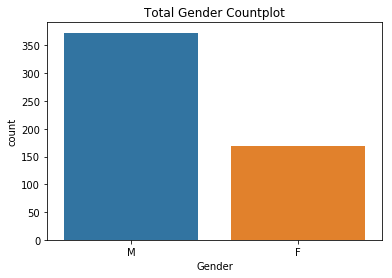

In [11]:
sns.countplot(x="Gender", data=df).set_title("Total Gender Countplot")
plt.show()


**Observation:**

- For the final dataset, we see the count of male reporters is more than twice the number of female reporters. (For the case of successful gender label)

### Reporters on the various domains
The data includes categories of reporting as :
 1. Technology
 2. Environment
 3. Health
 4. Others<br>
 In the analysis below, we can compare the popularity of each domain among reporters.

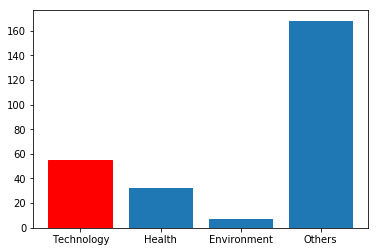

In [12]:
x = ['Technology','Health','Environment','Others']
y = [df['Technology'].sum(),df['Health&Medical'].sum(),df['Environment'].sum(),df['Others'].sum()]
barlist = plt.bar(x,y)
barlist[0].set_color("r")

plt.show()

From Observing the graph it is clear that the most of them are reporting on random or uncategorized issues.

### Top 10 countries with highest number of reporters

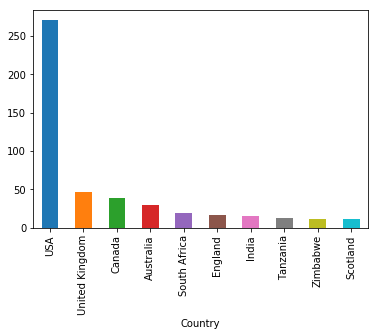

In [13]:
df.groupby(['Country'])["Reporter Name"].count().sort_values(ascending = False).head(10).plot.bar()

USA has the highest number of reporters with around ~45% of the share in the total data.

### Gender ratio in the top 5 countries with the maximux number of reporters

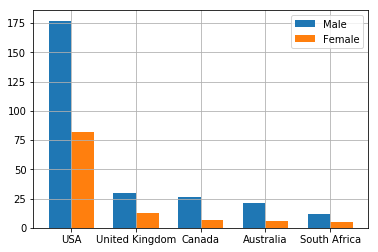

In [14]:
w=0.35
ind = np.arange(5)
male = df[(df["Gender"]=="M")].groupby(["Country"])["Reporter Name"].count().sort_values(ascending = False).head(5)
female = df[(df["Gender"]=="F")].groupby(["Country"])["Reporter Name"].count().sort_values(ascending = False).head(5)
plt.bar(ind, male, w, label="Male")
plt.bar(ind+w, female, w, label="Female")
plt.xticks(ind+w/2, male.keys())
plt.legend()
plt.grid()
plt.show()

Most of the countries have female:male ratio as less than half.

### Top 5 countries with the highest number of reports in the Technology domain

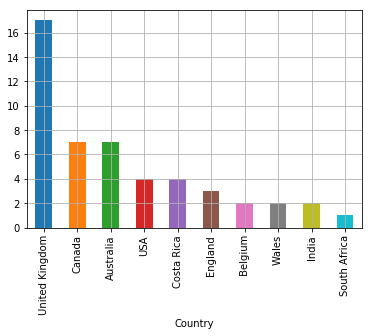

In [15]:
df[df["Technology"]==1].groupby(['Country'])["Reporter Name"].count().sort_values(ascending = False).head(10).plot.bar(grid=True)

Top Countries in technology reporting are United Kingdom, Canada, Australia , USA(surprisingly, it ranks 4th despite having maximum reporters in the world) .

(The actual count of reporter for each country is significantly less as compared to the entire data, thus this is not a strong conclusion)

### Top 5 countries with the highest number of reports in the Health and Medicine domain

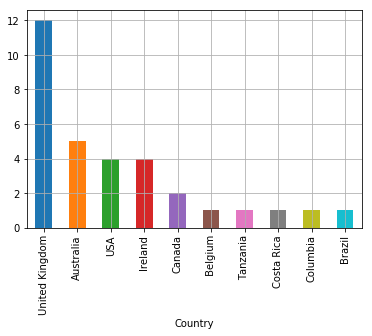

In [16]:
df[df["Health&Medical"]==1].groupby(['Country'])["Reporter Name"].count().sort_values(ascending = False).head(10).plot.bar(grid=True)

### Top 5 countries with the highest number of reports in the Environment domain

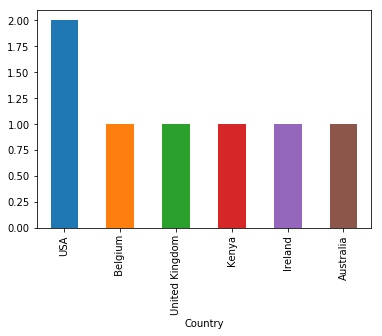

In [17]:
df[df["Environment"]==1].groupby(['Country'])["Reporter Name"].count().sort_values(ascending = False).head(10).plot.bar()

The count of reporters in Environment domain is low, thus we can't really confirm a pattern.

### People getting cited the most and their respective countries
#### Most Active Reporters
On the basis of number of citations on google scholar authored by a reporter , we estimated the activity of a reporter and how frequently they indulge .<br> 

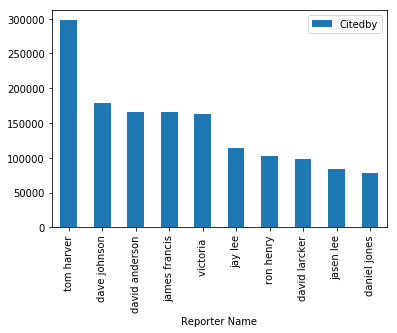

In [18]:
df[(df["Citedby"].notnull())][["Reporter Name", "Citedby", "Country"]].sort_values(by = ['Citedby'], ascending = False).head(10).plot.bar(x="Reporter Name")

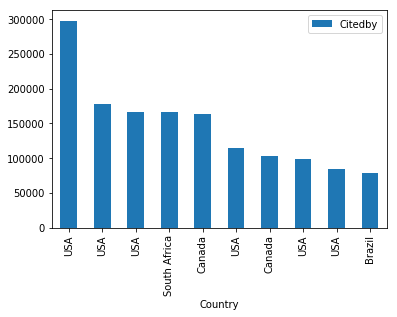

In [19]:
df[(df["Citedby"].notnull())][["Reporter Name", "Citedby", "Country"]].sort_values(by = ['Citedby'], ascending = False).head(10).plot.bar(x="Country")

Tom Harver being the reporter with highest citations (close to 0.3 million)

Further, we have grouped them on the basis of country, to deduce the country most active in reporting.
Top 3 actively reporting countries being:

1. United States of America
2. Canada
3. South Africa


## Analysing the Textual data

### Final preprocessing of Publication Text for exceptions

In [20]:
#function to remove stopwords
def secondClean(text):
    cleaned = firstClean(text)
    filtered_words = []
    for x in cleaned.split():
        if x not in stop_words:
            filtered_words.append(x)
    return " ".join(filtered_words).strip()

#conversion to processable string
def toString(x):
    try:
        return str(x)
    except:
        return 0
    
#cleaning html tags from text
def firstClean(text):
    return re.sub(r"[^A-Za-z\u00C0-\u00D6\u00D8-\u00f6\u00f8-\u00ff\s]","",text)
stop_words = stopwords.words('english')

In [21]:
df['Cleaned Publications'] = df['Cleaned Publications'].apply(lambda x:toString(x))

In [22]:
df['Cleaned Publications'] = df['Cleaned Publications'].apply(lambda x:secondClean(x))

In [23]:
#tfidf used to find relevant words in text
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(df['Cleaned Publications']))

vz.shape

(600, 8966)

In [24]:
tfidf = dict(zip(vectorizer.get_feature_names(),vectorizer.idf_))

In [25]:
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')

In [26]:
tfidf.columns = ['tfidf']

### Visualizing the textual data using Word Cloud

In [27]:
#higher tfidf score, more relevant words is to the context
tfidf.head()

,tfidf
abandoned,5.452685
abdominal,5.096010
aberrant,5.452685
aberrations,5.452685
abilities,4.508223


In [28]:
from wordcloud import WordCloud

def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(25, 25))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

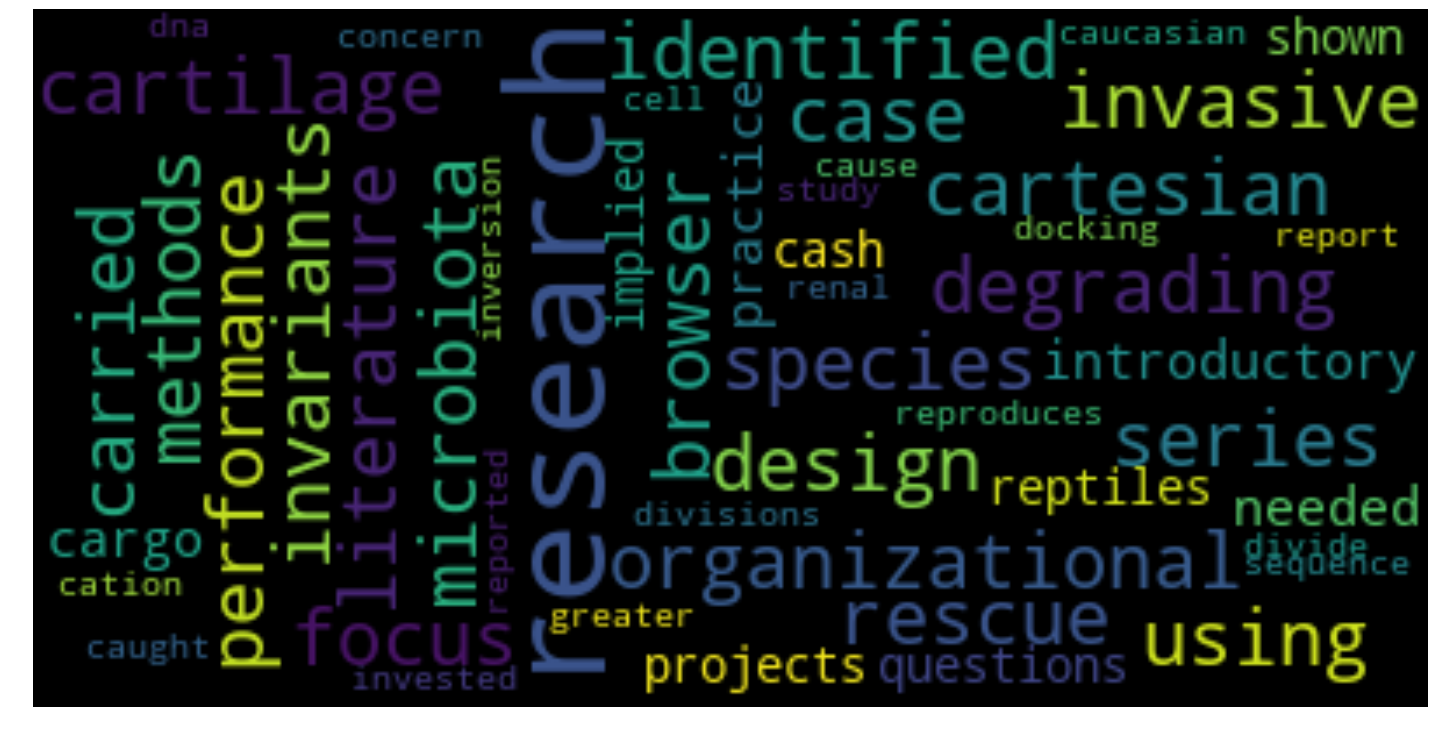

In [29]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

**Inference:**
This shows the TF-IDF cloud words based on the text of publications for each records,it is interesting to see that even though the data is dominated by tech reporters, TF-IDF shows words which are related to Health domains<br>
- cell 
- dna 
- renal 
- microbiota <br>
are some of such words

### Clustering Publication Text
Purpose is to find similar reporters based on their publications through Clustering.

In [30]:
# Single value reduction 
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

svd_tfidf.shape

(600, 50)

In [31]:
# T-distributed Stochastic Neighbor Embedding used. This helps in high level visualization
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2,perplexity=10, verbose=1, random_state=0, n_iter=2000)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
print(tsne_tfidf.shape)
tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
tsne_tfidf_df.columns = ['x', 'y']
tsne_tfidf_df['Category'] = df['Category']
tsne_tfidf_df['ReporterName'] = df['Reporter Name']

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.004s...
[t-SNE] Computed neighbors for 600 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.158728
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.166100
[t-SNE] KL divergence after 2000 iterations: 0.953784
(600, 2)


In [33]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the publications",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df['Category'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df['Category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'Category', 'transform': color_map}, 
                   legend='Category', source=tsne_tfidf_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Reporter Name": "@ReporterName", "Category":"@Category"}

show(plot_tfidf)

Loading BokehJS ...

Inference: 
- Nearest Neighbour Clustering based on TSNE shows that there are small clusters scattered all over the place, hence reporters are fairly diverse in their style of publications.<br>
- The clusters are really small, thus it doesnt make sense to analyze each and every small cluster

#### Distorsion and Silhouette Score on Publication

In [34]:
from tqdm import tqdm_notebook
distorsions = []
sil_scores = []
k_max = 100
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42,  
                         init_size=1000, verbose=False, max_iter=1000)
    kmeans_model.fit(vz)
    sil_score = silhouette_score(vz, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)

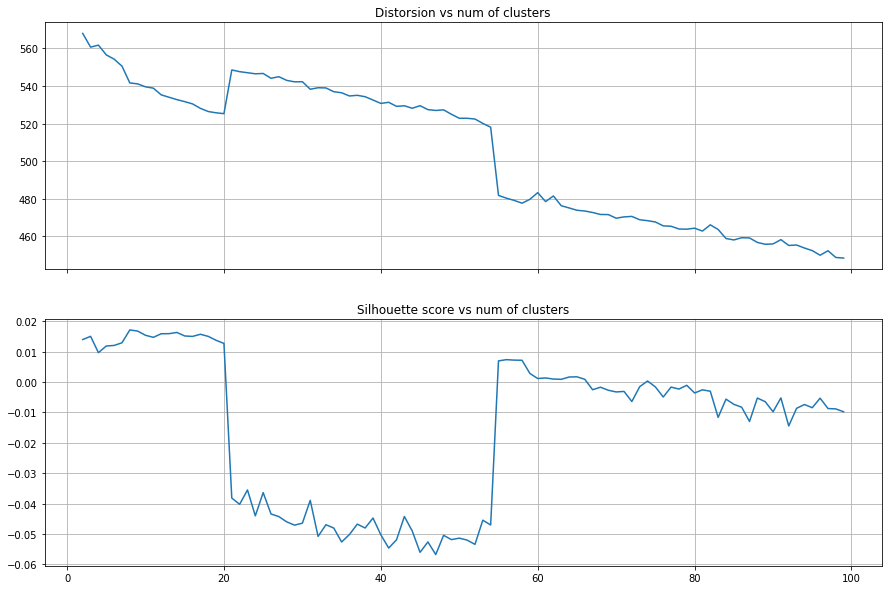

In [35]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

Above graph shows Error to accuracy data points for each K in K-means till 100, there is an abnormality after 20 till around ~50
we dont know the reason of such abnormality, we also dont have an elbow curve to determine which K would be more suited Since the error is still decreasing even after we reach k=100.<br>
We cannot chose a large K because we dont have enough data for it cluster properly.if we choose k=100 it will select 6 datapoints in for each clusters (total records ~600). and analyzing those 100 clusters would not be feasible

## Clustering on Affiliation
The Next interesting attribute to cluster on is on affiliation to find similarities,<br<
Affiliation gives details of what the reporter is affiliated to.<br>
It includes Names of Universities, State etc

#### Preprocessing Affiliations

In [36]:
df['Cleaned Affiliations'] = df['Affiliation'].apply(lambda x:secondClean(x))

In [37]:
vectorizerAff = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz1 = vectorizerAff.fit_transform(list(df['Cleaned Affiliations']))
df.reset_index(inplace =True)
vz1.shape

(600, 98)

In [38]:
#single value reduction 
svdAff = TruncatedSVD(n_components=50, random_state=0)
svd_tfidfAff = svdAff.fit_transform(vz1)
svd_tfidfAff.shape

(600, 50)

In [39]:
tsne_modelAff = TSNE(n_components=2,perplexity=10, verbose=1, random_state=0, n_iter=2000)
tsne_tfidfAff = tsne_modelAff.fit_transform(svd_tfidfAff)
print(tsne_tfidfAff.shape)
tsne_tfidf_dfAff = pd.DataFrame(tsne_tfidfAff)
tsne_tfidf_dfAff.columns = ['x', 'y']
tsne_tfidf_dfAff['Category'] = df['Category']
tsne_tfidf_dfAff['ReporterName'] = df['Reporter Name']
tsne_tfidf_dfAff['Affiliations'] = df['Cleaned Affiliations']

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.002s...
[t-SNE] Computed neighbors for 600 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.454361
[t-SNE] KL divergence after 2000 iterations: 0.576950
(600, 2)


In [40]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the affiliations",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_dfAff['Category'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_dfAff['Category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'Category', 'transform': color_map}, 
                   legend='Category', source=tsne_tfidf_dfAff)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Reporter Name": "@ReporterName", "Category":"@Category","Affiliations":"@Affiliations"}

show(plot_tfidf)

Loading BokehJS ...

Observation:
The bottom most cluster are associated to unknown attributes.<br>
And the rightmost cluster belongs to PHDs and Stanford university.

#### Finding Distorsion and Silhouette Scores for Affiliations

In [41]:
distorsions = []
sil_scores = []
k_max = 100
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42,  
                         init_size=1000, verbose=False, max_iter=1000)
    kmeans_model.fit(vz1)
    sil_score = silhouette_score(vz1, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)

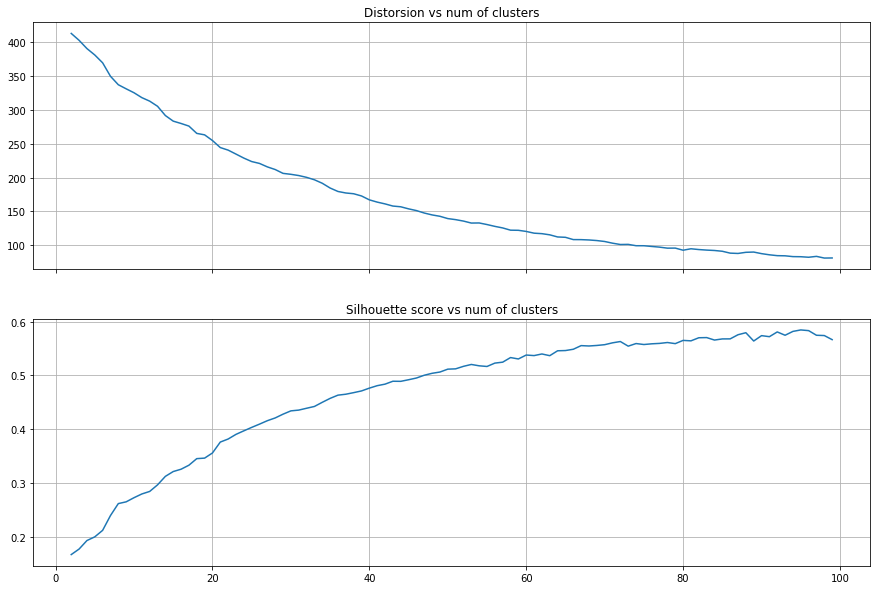

In [42]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters')
ax2.grid(True)

There isnt a elbow curve which would tell us the optimal K, And since the error keeps on reducing it difficult to know whats the correct K.<br> Hence we have choose the ratio of errors in the interval of K values, <br>
The error rate curve decreases less lower  in between 20-40 as compared to the interval below 20.<br>
and hence k is selected as 20 to make sure there are good number of clusters aswell.

In [43]:
num_clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, )
kmeans = kmeans_model.fit(vz1)
kmeans_clusters = kmeans.predict(vz1)
kmeans_distances = kmeans.transform(vz1)

### Affiliations : Clusters key words

In [44]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizerAff.get_feature_names()
all_keywords = []
for i in range(kmeans.n_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['cluster_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
cluster_0,university,professor,state university,state,school,engineering,laboratory,student,stanford,phd
cluster_1,university,texas,york,harvard,doctoral,economics,engineering,environmental,faculty,federal
cluster_2,universidad,del,researcher,professor,york,george,doctoral,economics,engineering,environmental
cluster_3,affiliation,unknown affiliation,unknown,harvard,doctoral,economics,engineering,environmental,faculty,federal
cluster_4,professor university,professor,university,associate professor,associate,columbia,germany,michigan,colorado,distinguished
cluster_5,center,medical center,medical,university,professor,columbia,harvard,washington,george,national
cluster_6,professor,university,york,harvard,economics,engineering,environmental,faculty,federal,fellow
cluster_7,scientist,senior,assistant,international,computer,science,university,york,florida,economics
cluster_8,research fellow,fellow,research,university,hospital,newcastle,national,stanford university,postdoctoral,stanford
cluster_9,hospital,university,oxford,professor,department,center,york,germany,engineering,environmental


In [45]:
tsne_tfidf_dfAff['clusters'] = kmeans_clusters
kmeans.n_clusters

20

In [46]:
kmeans_clusters1 = list(map(str,kmeans_clusters))
tsne_tfidf_dfAff.head()

,x,y,Category,ReporterName,Affiliations,clusters
0,-9.728665,-1.908636,Magazine,diego bernardini,Instituto Universitario de Ciencias Medicas Fu...,0
1,-18.391047,-1.789205,Magazine,raquel beer,Teacher Department Nursing Faculty Health Scie...,11
2,37.898724,-33.167332,Newspaper,conrado moreno,Profesor del Centro de Estudio de Tecnologias ...,2
3,38.114857,-33.231438,Newspaper,rosario medina,Universidad del Rosario Facultad de Jurisprude...,2
4,36.284264,-32.078583,Newspaper,javier sampedro,Catedrático de ciencias del deporte,0


In [47]:
color_lookup = dict(zip(set(kmeans_clusters),palette))
tsne_tfidf_dfAff['colors'] = tsne_tfidf_dfAff['clusters'].apply(lambda x:color_lookup.get(x))

In [48]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the affiliations",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category20'][kmeans.n_clusters]
color_map = bmo.CategoricalColorMapper(factors=list(set(kmeans_clusters1)), palette=palette)

plot_tfidf.scatter(x='x', y='y', color='colors', 
                   legend='clusters', source=tsne_tfidf_dfAff)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Reporter Name": "@ReporterName", "Category":"@Category","Cluster#":"@clusters","Affiliations":"@Affiliations"}

show(plot_tfidf)

Loading BokehJS ...

### Clustering on Interests
Next interesting attribute to look at is interest , although this doesnt hold that much significance in terms of reporting, it could still give us a fair idea of how similar the interests of reporters are.

#### Preprocessing Text of Interests

In [49]:
df['Interests'] = df['Interests'].apply(lambda x:toString(x))
df['Cleaned Interests'] = df['Interests'].apply(lambda x:secondClean(x))
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz2 = vectorizer.fit_transform(list(df['Cleaned Interests']))

vz2.shape

(600, 105)

In [50]:
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svdAff.fit_transform(vz2)
svd_tfidf.shape

(600, 50)

In [51]:
tsne_model = TSNE(n_components=2,perplexity=10, verbose=1, random_state=0, n_iter=2000)
tsne_tfidf = tsne_modelAff.fit_transform(svd_tfidf)
print(tsne_tfidf.shape)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.002s...
[t-SNE] Computed neighbors for 600 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.665688
[t-SNE] KL divergence after 2000 iterations: 0.713738
(600, 2)


In [52]:
tsne_tfidf_df1 = pd.DataFrame(tsne_tfidf)
tsne_tfidf_df1.columns = ['x', 'y']
tsne_tfidf_df1['Category'] = df['Category']
tsne_tfidf_df1['ReporterName'] = df['Reporter Name']
tsne_tfidf_df1['Interests'] = df['Interests']

In [53]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the interests",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category10'][len(tsne_tfidf_df1['Category'].unique())]
color_map = bmo.CategoricalColorMapper(factors=tsne_tfidf_df1['Category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x='x', y='y', color={'field': 'Category', 'transform': color_map}, 
                   legend='Category', source=tsne_tfidf_df1)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Reporter Name": "@ReporterName", "Category":"@Category","Interests":"@Interests"}

show(plot_tfidf)

Loading BokehJS ...

#### Distorsion and Silhouette Scores for Interests

In [54]:
distorsions = []
sil_scores = []
k_max = 100
for k in tqdm_notebook(range(2, k_max)):
    kmeans_model = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42,  
                         init_size=1000, verbose=False, max_iter=1000)
    kmeans_model.fit(vz2)
    sil_score = silhouette_score(vz2, kmeans_model.labels_)
    sil_scores.append(sil_score)
    distorsions.append(kmeans_model.inertia_)

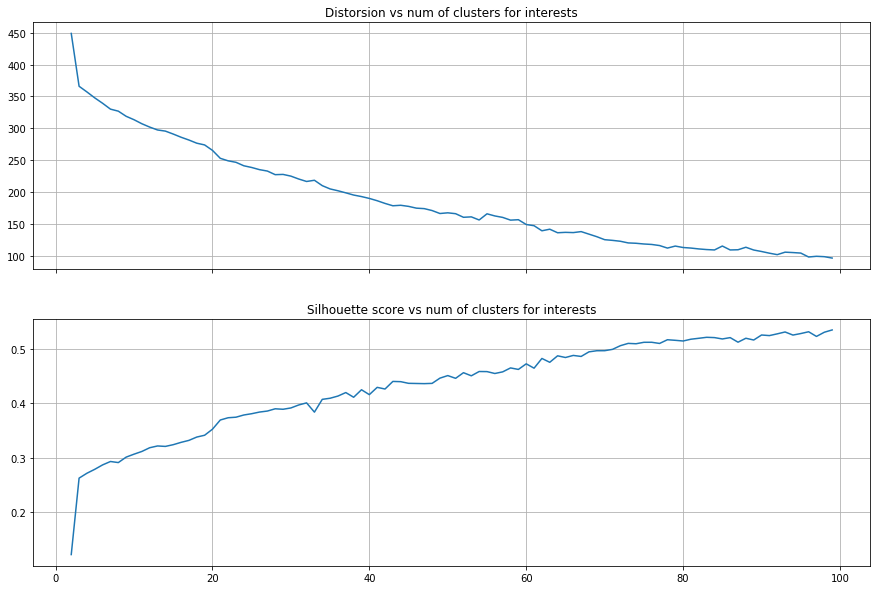

In [55]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

ax1.plot(range(2, k_max), distorsions)
ax1.set_title('Distorsion vs num of clusters for interests')
ax1.grid(True)

ax2.plot(range(2, k_max), sil_scores)
ax2.set_title('Silhouette score vs num of clusters for interests')
ax2.grid(True)

#### Clustering

In [56]:
num_clusters = 20
kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, init='k-means++', n_init=1, random_state=42,                       
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000, )
kmeans = kmeans_model.fit(vz2)
kmeans_clusters = kmeans.predict(vz2)
kmeans_distances = kmeans.transform(vz2)

In [57]:
tsne_tfidf_df1['clusters'] = kmeans_clusters
tsne_tfidf_df1['colors'] = tsne_tfidf_df1['clusters'].apply(lambda x:color_lookup.get(x))

In [58]:
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="tf-idf clustering of the interests",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

palette = d3['Category20'][kmeans.n_clusters]
color_map = bmo.CategoricalColorMapper(factors=list(set(kmeans_clusters1)), palette=palette)

plot_tfidf.scatter(x='x', y='y', color='colors', 
                   legend='clusters', source=tsne_tfidf_df1)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"Reporter Name": "@ReporterName", "Category":"@Category","Cluster#":"@clusters","Interests":"@Interests"}

show(plot_tfidf)

Loading BokehJS ...

Here,  the majority of interests are included in cluster 0 and small clusters are scattered all over the place. Thus no strong similarity in interests noted.

#### Clusters of Keywords 

In [59]:
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
all_keywords = []
for i in range(kmeans.n_clusters):
    topic_keywords = []
    for j in sorted_centroids[i, :10]:
        topic_keywords.append(terms[j])
    all_keywords.append(topic_keywords)

keywords_df = pd.DataFrame(index=['cluster_{0}'.format(i) for i in range(num_clusters)], 
                           columns=['keyword_{0}'.format(i) for i in range(10)],
                           data=all_keywords)
keywords_df

,keyword_0,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,keyword_6,keyword_7,keyword_8,keyword_9
cluster_0,science,learning,social,machine,physics,analysis,machine learning,systems,computer,information
cluster_1,nan,theory,design,digital,dynamics,ecology,economics,education,energy,engineering
cluster_2,engineering,software engineering,systems,software,human,management,programming,information,interaction,computer
cluster_3,health,public health,public,global,medical,psychology,care,human,research,cancer
cluster_4,ecology,evolutionary,biology,evolution,theory,digital,dynamics,economics,education,energy
cluster_5,cognitive,psychology,recognition,neural,law,theory,environmental,digital,dynamics,ecology
cluster_6,genetics,bioinformatics,genomics,gene,research,biology,computational biology,nuclear,computational,human
cluster_7,conservation,ecology,biology,conservation biology,animal,marine,science,management,materials,natural
cluster_8,cancer,biology,clinical,physics,research,digital,dynamics,ecology,economics,education
cluster_9,medicine,care,nuclear,physics,health,global,science,environmental,development,digital


Cluster 0 is the biggest cluster but after looking the most frequent keyword it is still difficult to form a judgement on the interests.

## Bigram analysis on Affiliations
Since with single words it is difficult to form an opinion , bigrams would help us to form a better inference of the common context in various texts.

In [60]:
text = list(df['Cleaned Affiliations'])

In [61]:
bigrams = [b for l in text for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]

In [62]:
from collections import Counter
counter = Counter()
for l in text:
    for t in range(0,len(l.split(" "))-1):
        counter.update([l.split(" ")[t]+" "+l.split(" ")[t+1]])
counter.most_common(10)

[('Unknown affiliation', 26),
 ('State University', 21),
 ('Associate Professor', 20),
 ('Assistant Professor', 11),
 ('Medical Center', 10),
 ('Professor University', 10),
 ('University North', 9),
 ('North Carolina', 8),
 ('University California', 8),
 ('Computer Science', 8)]

There are around 600 records and within these records only 26 Unknown affiliations occur> like wise with other bigrams, it could mean the affiliations are varied. Though, State University and Associate/Assistant Professors seem to lead in the data.

## Bigram Analysis on Interests

In [63]:
InterestText = df['Cleaned Interests'].str.lower()
InterestCounter = Counter()
for l in InterestText:
    for t in range(0,len(l.split(" "))-1):
        InterestCounter.update([l.split(" ")[t]+" "+l.split(" ")[t+1]])
InterestCounter.most_common(10)

[('machine learning', 14),
 ('artificial intelligence', 7),
 ('software engineering', 6),
 ('natural language', 6),
 ('public health', 5),
 ('data science', 5),
 ('language processing', 5),
 ('conservation biology', 5),
 ('computational biology', 5),
 ('molecular biology', 4)]

The counts though insignificant in comparison to the total data, but we can identify a general trend  Interests have a bend towards scientific  topics like Machine Learning ,Natural Language Processing and Biology.

## Bigram Analysis on Publication Text

In [64]:
PublicationCounter = Counter()
PublicationTexts = df['Cleaned Publications']
for l in tqdm_notebook(PublicationTexts):
    for t in range(0,len(l.split(" "))-1):
        PublicationCounter.update([l.split(" ")[t]+" "+l.split(" ")[t+1]])

In [65]:
PublicationCounter.most_common(20)

[('united states', 136),
 ('present study', 82),
 ('results show', 81),
 ('paper presents', 77),
 ('climate change', 73),
 ('gene expression', 65),
 ('mental health', 64),
 ('risk factors', 61),
 ('case study', 59),
 ('health care', 57),
 ('age years', 57),
 ('purpose study', 55),
 ('wide range', 55),
 ('recent years', 53),
 ('older adults', 53),
 ('results indicate', 52),
 ('data collected', 49),
 ('aim study', 48),
 ('little known', 48),
 ('magnetic resonance', 47)]

No strong inference can be judged from here. Though, health and medicine seem to be a more commonly discussed subject.
